In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from songs import *

# грузим все песенки и все их транспонированные версии
Songs = []
for i in range(1, 35):
    song = Song('basic midi/track (' + str(i) + ').mid')
    while song.transpose(1):
        pass
    
    Songs.append(song.notes)
    while song.transpose(-1):
        Songs.append(song.notes)
    
Songs = np.array(Songs)
Songs.shape

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


(69, 128, 13)

## Запихиваем в HistoryUser музыку
Архитектура в точности та же, что и в экспериментах, за тем исключением, что лосс считается по всей последовательности, а ответ - это следующий вход.

In [3]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same as first 128 of input
tf.reset_default_graph()

# Network Parameters
learning_rate = 0.001
batch_size = Songs.shape[0]
num_input = 13       # dimension of one input at moment
timesteps = 128   # timesteps in one sequence
num_hidden = 70      # num of lstms in first hidden layer
num_read = 50        # num of lstms in second hidden layer
num_final = 90       # num of lstms in final hidden layer
history_size = 80    # how much previous moments of input is stored

# tf graph input
X = tf.placeholder("float", [batch_size, timesteps, num_input])

# loss will be calculated in the loop as sum of losses on each iteration
loss_op = tf.constant(0.0)

# defining first hidden layer
with tf.variable_scope('first_lstm'):
    first_lstm = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    first_lstm_state = tf.zeros([batch_size, num_hidden]), tf.zeros([batch_size, num_hidden])

# defining second hidden layer
with tf.variable_scope("read_lstm"):
    read_lstm = tf.contrib.rnn.BasicLSTMCell(num_read, forget_bias=1.0)
    read_lstm_state = tf.zeros([batch_size, num_read]), tf.zeros([batch_size, num_read])

# linear transformation of second lstm cell outputs to history size dimension vector
read_w = tf.Variable(tf.random_normal([num_read, history_size]))
read_b = tf.Variable(tf.random_normal([history_size]))

# history is an array of previous (in time) history_size inputs
history = tf.zeros([batch_size, num_input, history_size])

# defining common hidden layer
with tf.variable_scope("final_lstm"):
    final_lstm = tf.contrib.rnn.BasicLSTMCell(num_final, forget_bias=1.0)
    final_lstm_state = tf.zeros([batch_size, num_final]), tf.zeros([batch_size, num_final])
    
# linear transformation to final output
final_w = tf.Variable(tf.random_normal([num_final, num_input]))
final_b = tf.Variable(tf.random_normal([num_input]))

# reshaping data to (timesteps, batch_size, num_input)
_X = tf.unstack(X, timesteps, 1)

# time loop
readings_log = []
outputs = []
for t, inp, truth in zip(np.arange(timesteps - 1), _X[:-1], _X[1:]):
    # moving data through lstm layers
    with tf.variable_scope('first_lstm'):
        first_lstm_output, first_lstm_state = first_lstm(inp, first_lstm_state)
    with tf.variable_scope("read_lstm"):
        read_lstm_output, read_lstm_state = read_lstm(first_lstm_output, read_lstm_state)
    
    # linear transformation to vector of history_size length
    read = tf.matmul(read_lstm_output, read_w) + read_b
    # transformation to "probabilities"-kind weights    
    read_proba = tf.nn.softmax(read, 1)
    readings_log.append(read_proba)
    # taking selected data from memory
    memory_retrieve = tf.matmul(history, tf.expand_dims(read_proba, 2))
    
    # rolling history
    history = tf.concat([history[:, :, 1:], tf.expand_dims(inp, 2)], axis=2)
    
    # moving through final lstm layer
    with tf.variable_scope("final_lstm"):
        final_lstm_output, final_lstm_state = final_lstm(tf.concat([inp, tf.squeeze(memory_retrieve, 2)], axis=1), 
                                                         final_lstm_state)
    
    # calculating final ans
    output = tf.matmul(final_lstm_output, final_w) + final_b    
    outputs.append(output)
    
    # calculate loss
    loss_op += tf.reduce_mean(tf.squared_difference(output, truth))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)

sess = tf.Session(config = config)
# Run the initializer
sess.run(init)

losses = []

In [5]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: Songs})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: Songs})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 118.6448
Step 100, Minibatch Loss= 6.1364
Step 200, Minibatch Loss= 4.8948
Step 300, Minibatch Loss= 4.3541
Step 400, Minibatch Loss= 3.9581
Step 500, Minibatch Loss= 3.5335
Step 600, Minibatch Loss= 3.0469
Step 700, Minibatch Loss= 2.5633
Step 800, Minibatch Loss= 2.3136
Step 900, Minibatch Loss= 2.4386
Optimization Finished!


### Кажется, мы легко переобучились...

In [6]:
print("forgot to print loss on final step: ", L)

forgot to print loss on final step:  1.89025


### ОЧЕНЬ хорошо

## Посмотрим, что получилось на примере кузнечика

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw(data, outp, scalex=192.0 / 7, scaley=30.0 / 7):
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(scalex, scaley))
    f.subplots_adjust(hspace=0)
    ax1.set_title("true data")
    ax1.imshow(data.T, aspect='auto')
    ax2.set_title("output", y = -0.3)
    ax2.imshow(outp.T, aspect='auto')
    ax2.set_xticks(np.arange(0, 128, 4))
    plt.show()
    
def drawr(readings, scalex=192.0 / 10, scaley=80.0 / 10):
    plt.figure(figsize=(scalex, scaley))
    plt.title("readings")
    plt.imshow(readings.T, aspect='auto')
    plt.xlabel("time")
    plt.xticks(np.arange(0, 128, 4))
    plt.show()

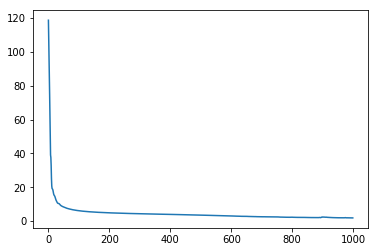

In [8]:
plt.plot(losses)  # потери при обучении

In [9]:
outp = np.array(sess.run(outputs, feed_dict={X: Songs}))
outp.shape

(127, 69, 13)

In [11]:
outp = np.rollaxis(outp, 1)  # выходов 127, потому что первый вход мы не предсказываем
outp.shape

(69, 127, 13)

Сравним кузнечика и предсказания сети. Помним, что мы вроде как переобучились.

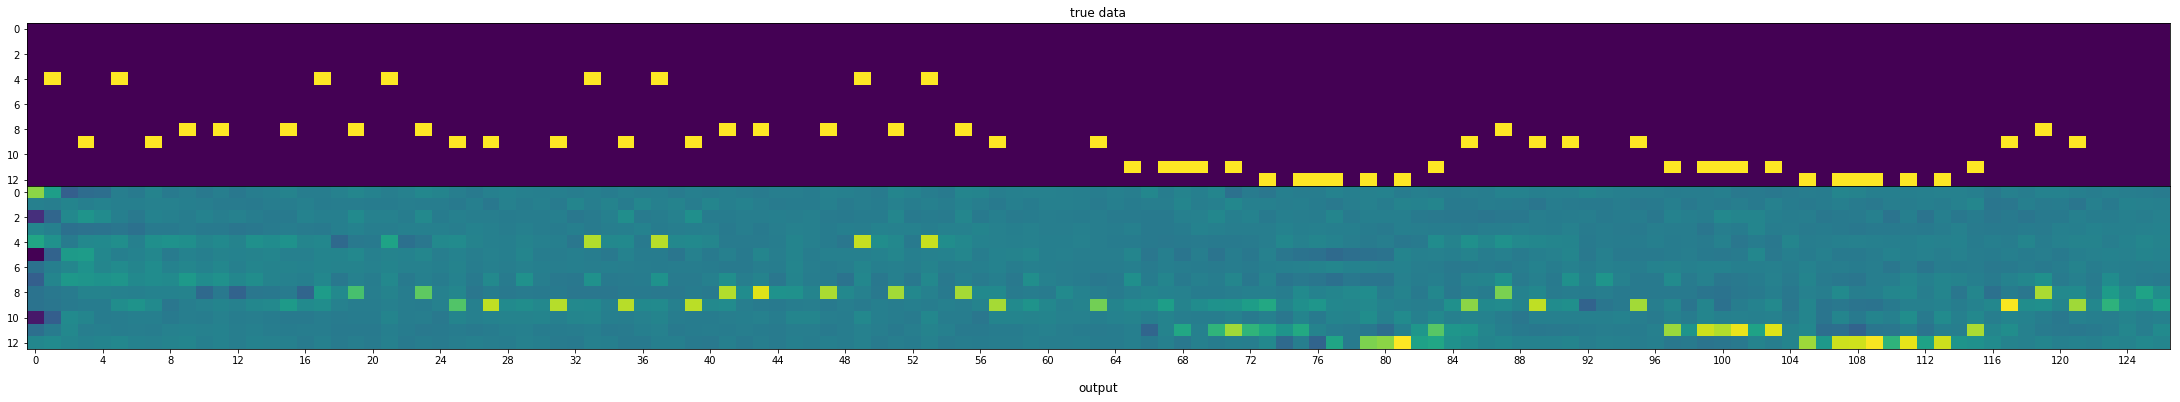

In [49]:
draw(Songs[0, 1:, :], outp[0, :, :], scalex=192.0 / 5, scaley=30.0 / 5)

Отлично видно, что повторения (32-64, 96-128) предсказываются лучше, чем первые итерации.

In [18]:
readings = np.array(sess.run(readings_log, feed_dict={X: Songs}))
readings.shape

(127, 69, 80)

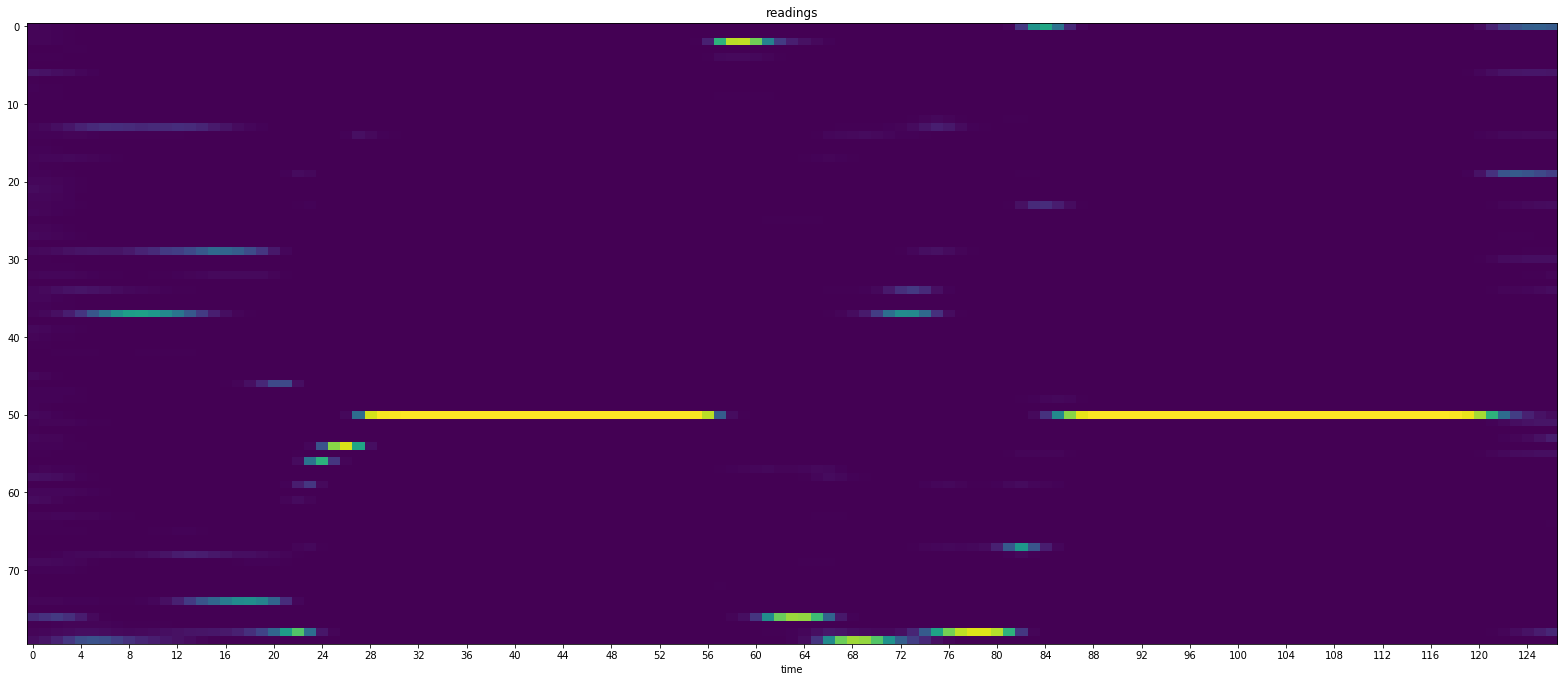

In [43]:
drawr(readings[:, 0, :], scalex=192.0 / 7, scaley=80.0 / 7)  # график вектора считывания для кузнечика

на рисунке выше есть проблемы с вертикальной осью. Это plt.imshow() прикалывается: она по идее не от 0 до 80, а наоборот должна идти.

Далее, в 0-ом элементе "истории" лежит то, что относительно предсказания было 2 момента времени назад (то, что было 1 момент времени назад, подаётся на вход).

Посмотрим, куда в историю он смотрит "чаще" всего

<Container object of 80 artists>

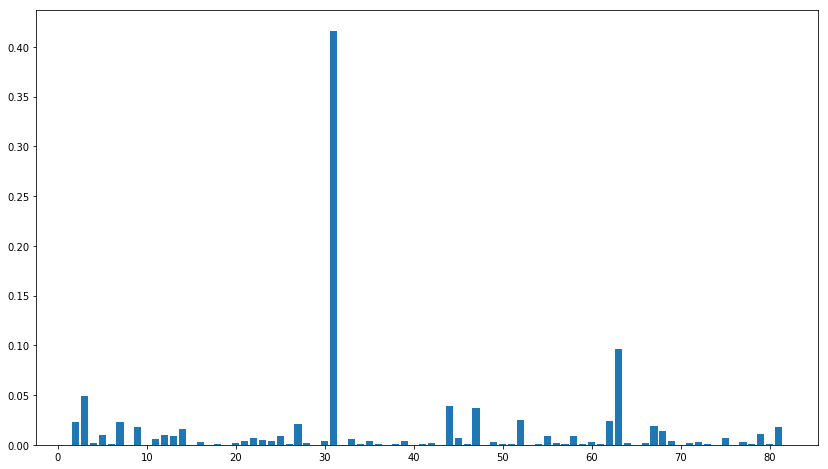

In [47]:
plt.figure(figsize=(14, 8))
plt.bar(np.arange(0, 80)[::-1] + 2, readings[:, :, :].mean(axis=0).mean(axis=0))

Не понимаю, почему 31 и 63... Должно быть 32 и 64 =D Куда-то девается ещё один индекс?..

# Генерация

Код пока не предусматривает генерацию на ходу, поэтому будет немного извращений... batch_size тоже фиксированный, потому что иначе batch_matmul-у в тензорфлоу что-то не нравится, так что будем генерить сразу 69 песенок...

Процесс генерации пока от балды - каждой ноте нейронка выдаёт какое-то число, скорее всего ближе к нулю или единице, и непонятно, сколько нот нужно брать, например.

In [110]:
notes = np.zeros((69, 128, 13))
notes[np.arange(69), np.zeros(69, dtype=int), np.random.randint(0, 13, size=69)] = 1  # first note is one and random

In [111]:
for t in range(127):
    outp = np.array(sess.run(outputs, feed_dict={X: notes}))
    outp = np.rollaxis(outp, 1)
    is_note = np.random.uniform(size=69) < outp[:, t].sum(axis=1)
    
    outp[outp < 0] = 0
    outp[outp > 1] = 1
    outp /= outp.sum(axis=2)[:,:,None]

    next_note = np.zeros((69, 13))
    for i in range(69):
        if is_note[i]:
            next_note[i, np.random.choice(np.arange(13), p=outp[i, t])] = 1
    notes[:, t+1, :] = next_note

In [124]:
MySong(notes[8]).play()  # играем песенку

In [122]:
# сохраняем в файл
#MySong(notes[6]).save_file("HistoryUser(2-layer LSTM) united with inputs (1-layer LSTM) trained on 35 songs (good example).mid")